In [1]:
import pandas as pd
import numpy as np
from fastai.core import *
from PIL import Image
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [2]:
import json
from collections import defaultdict
import pdb
import numpy as np
from collections import defaultdict

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
coco = Path('dataset1.v1.coco')
# coco = untar_data('classroomtest.coco.zip')
img_dir = Path('dataset1.v1.coco/images')
annotations_train = Path('dataset1.v1.coco/annotation/train_annotations.coco.json')
annotations_valid = Path('dataset1.v1.coco/annotation/valid_annotations.coco.json')

# annotation 여기에선 데이터 한꺼번에 불러오길래
# train val images 합쳐서 넣음
images, lbl_bbox = get_annotations(annotations_train)
images_,lbl_bbox_ = get_annotations(annotations_valid)
images.extend(images_)
lbl_bbox.extend(lbl_bbox_)


In [4]:
with open(annotations_train) as f:
    train_json = json.load(f)
    
ncat = len(train_json['categories'])
train_json['categories']

[{'id': 0, 'name': 'dataset1', 'supercategory': 'none'},
 {'id': 1, 'name': '1', 'supercategory': 'dataset1'},
 {'id': 2, 'name': '3', 'supercategory': 'dataset1'},
 {'id': 3, 'name': '4', 'supercategory': 'dataset1'},
 {'id': 4, 'name': '5', 'supercategory': 'dataset1'},
 {'id': 5, 'name': '6', 'supercategory': 'dataset1'},
 {'id': 6, 'name': '7', 'supercategory': 'dataset1'},
 {'id': 7, 'name': '8', 'supercategory': 'dataset1'},
 {'id': 8, 'name': '9', 'supercategory': 'dataset1'},
 {'id': 9, 'name': 'eye', 'supercategory': 'dataset1'},
 {'id': 10, 'name': 'eye_close', 'supercategory': 'dataset1'},
 {'id': 11, 'name': 'eye_open', 'supercategory': 'dataset1'},
 {'id': 12, 'name': 'half_close', 'supercategory': 'dataset1'},
 {'id': 13, 'name': 'half_closed', 'supercategory': 'dataset1'},
 {'id': 14, 'name': 'open_eye', 'supercategory': 'dataset1'}]

In [5]:
for idx, lbl in enumerate(lbl_bbox):
    if len(lbl[1]) == 0:
        print(f"found empty annotation: {idx}")

In [6]:
## 돌렸을때 경고문구는 원래그럼. 예제에도 있었음.


img_list = ImageList.from_folder(img_dir)
#image size
sz = 224
# print(len(img_list))

img2bbox = dict(zip(images, lbl_bbox))
# img2bbox.sort()
print(type(images))
# cnt = 0
def get_y_func(o):
    filename = o.name
    if img2bbox.get(o.name):
        return img2bbox[o.name]
    else:
        # 데이터가 다 잘 들어간걸 확인했는데도 자꾸 오류가 나서 넣은 코드
        # 라벨링이 안된 사진이 들어갔을때 나는 오류라서
        # 임의로 bbox 리턴. 데이터 교체하면 오류 없을것.
        return [[[128, 148, 290, 217.5], [152, 162, 170.5, 178]], ['4', 'eye_opened']]

# ver 2
data = (ObjectItemList.from_folder(img_dir)
        .split_by_folder()                          
        .label_from_func(get_y_func)
        .transform(get_transforms(), tfm_y=True, size=224)
        .databunch(bs=8, collate_fn=bb_pad_collate, num_workers=0)
        .normalize(imagenet_stats)
        ) 
# data.add_test_folder(ObjectItemList.from_folder('test')
#              .split_none()
#              .transform(size=224)
#             .databunch(bs=8, collate_fn=bb_pad_collate, num_workers=0)
#             .normalize(imagenet_stats)
#             )

# Test = (ObjectItemList.from_folder(img_dir/'test')
#              .split_none()
#              .transform(size=224)
#             .databunch(bs=8, collate_fn=bb_pad_collate, num_workers=0)
#             .normalize(imagenet_stats))
# ver original
# data = (ObjectItemList.from_folder('dataset1.v1.coco/images')
#         .split_by_folder()                          
#         .label_from_func(get_y_func)
#         .transform(get_transforms(), tfm_y=True, size=224)
#         .databunch(bs=8, collate_fn=bb_pad_collate, num_workers=0)
#         .normalize(imagenet_stats)
#        )

data

<class 'list'>


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


ImageDataBunch;

Train: LabelList (605 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: dataset1.v1.coco\images;

Valid: LabelList (173 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: dataset1.v1.coco\images;

Test: None

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\vision\data.py:361: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  if len((labels - self.pad_idx).nonzero()) == 0: return


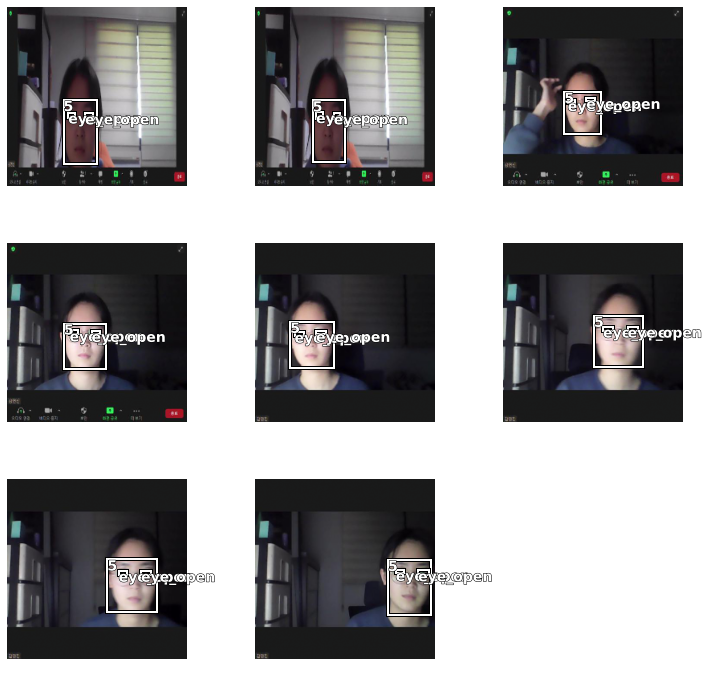

In [7]:
data.show_batch(rows=3, ds_type= DatasetType.Valid, figsize=(10,10))

In [8]:
# for idx, lbl in enumerate(lbl_bbox):
#     if len(lbl[1]) == 0:
#         print(f"found empty annotation: {idx}")

        
# with open(annotations_train) as f:
#     train_json = json.load(f)

# ncat = len(train_json['categories'])
# train_json['categories']
# custom_head= 만들면 최고....

In [9]:
# def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

# # str 중심값, bbox 가로세로 메트릭스 연산으로 꼭지점 좌표 구하기
# # 그 좌표를 이용해서 anchor 박스보여주기

# def create_anchors(ncells=[4], zooms=[1.],ratios=[(1.,1.)]):
#     a_scales = [(z*i,z*j) for z in zooms for (i,j) in ratios]
#     k = len(a_scales)
#     a_x = np.concatenate([np.repeat(np.linspace(-1+1/nc, 1-1/nc, nc), nc) 
#                           for nc in ncells])
#     a_y = np.concatenate([np.tile(np.linspace(-1+1/nc, 1-1/nc, nc), nc)
#                           for nc in ncells])
#     a_ctrs = np.repeat(np.stack([a_x, a_y], axis=1), k, axis=0)
#     a_sz = np.concatenate([np.array([[2*o/nc,2*p/nc] 
#                                      for i in range(nc*nc)
#                                      for o,p in a_scales])
#                            for nc in ncells])
#     grid_sz = np.concatenate([np.array([2/nc 
#                                         for i in range(nc*nc)
#                                         for o,p in a_scales])
#                               for nc in ncells])
#     anc = np.concatenate([a_ctrs, a_sz], axis=1)
#     grid_sizes = torch.tensor(grid_sz).type(torch.FloatTensor).unsqueeze(1).cuda()
#     anchors = torch.tensor(anc).type(torch.FloatTensor).cuda()
#     anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
#     return anchors, anchor_cnr, grid_sizes

In [10]:
# anchors, anchor_cnr, grid_sizes = create_anchors(ncells=[4,2,1],
#                                                  zooms=[0.7, 1., 1.3],
#                                                  ratios=[(1.,1.), (1., 0.5), (0.5, 1.)])

In [11]:

# def intersect(box_a, box_b):
#     max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
#     min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
#     inter = torch.clamp((max_xy - min_xy), min=0)
#     return inter[:, :, 0] * inter[:, :, 1]

# def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

# def jaccard(box_a, box_b):
#     inter = intersect(box_a, box_b)
#     union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
#     return inter / union

# def map_to_ground_truth(overlaps, print_it=False):
#     prior_overlap, prior_idx = overlaps.max(1)
#     if print_it: print(prior_overlap)
# #     pdb.set_trace()
#     gt_overlap, gt_idx = overlaps.max(0)
#     gt_overlap[prior_idx] = 1.99
#     for i,o in enumerate(prior_idx): gt_idx[o] = i
#     return gt_overlap,gt_idx

# def actn_to_bb(actn, anchors):
#     actn_bbs = torch.tanh(actn)
#     actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
#     actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
#     return hw2corners(actn_centers, actn_hw)


In [12]:
# def one_hot_embedding(labels, num_classes):
#     return torch.eye(num_classes)[labels.data.cpu()]

# class BCE_Loss(nn.Module):
#     def __init__(self, num_classes=14):
#         super().__init__()
#         self.num_classes = num_classes

#     def forward(self, pred, targ):
#         t = one_hot_embedding(targ, self.num_classes+1)
# #         t = t[:,:-1].contiguous().cuda()
# #         x = pred[:,:-1]
#         # in fastai v1, the background is encoded as the first class, rather than the last one
#         t = t[:,1:].contiguous().cuda()
#         x = pred[:,1:]
#         w = self.get_weight(x,t)
#         return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
#     def get_weight(self,x,t): return None
    
# class FocalLoss(BCE_Loss):
#     def get_weight(self,x,t):
#         alpha,gamma = 0.25,2.
#         p = x.sigmoid()
#         pt = p*t + (1-p)*(1-t)
#         w = alpha*t + (1-alpha)*(1-t)
#         return (w * (1-pt).pow(gamma)).detach()

# loss_f = FocalLoss(ncat)


In [13]:
# # remove padding - 이미지속에 존재하는 오브잭트 수가 각각 달라서 발생하는 문제를 해결하기 위해
# # 가장 많은걸 기준으로 0으로 패딩 넣음

# def get_y(bbox,clas):
#     bbox = bbox.view(-1,4)
#     bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
#     return bbox[bb_keep],clas[bb_keep]

# def ssd_1_loss(pred_bbox,pred_clas,bbox,clas):
#     bbox,clas = get_y(bbox,clas)
#     if len(bbox) == 0 and len(clas) == 0:
#         return 0.0, 0.0
#     a_ic = actn_to_bb(pred_bbox, anchors)
#     overlaps = jaccard(bbox.data, anchor_cnr.data)
#     gt_overlap,gt_idx = map_to_ground_truth(overlaps,False)
#     gt_clas = clas[gt_idx]
#     pos = gt_overlap > 0.4
#     pos_idx = torch.nonzero(pos)[:,0]
#     gt_clas[~pos] = 0 # background coded as 0
#     gt_bbox = bbox[gt_idx]
#     loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
#     clas_loss  = loss_f(pred_clas, gt_clas)
#     #print(f"loc_loss: {loc_loss}, clas_loss: {clas_loss}")
#     return loc_loss, clas_loss

# def ssd_loss(pred,targ_bb,targ_c):
#     lcs,lls = 0.,0.
# #    i = 1
# #    for b_c,b_bb,bbox,clas in zip(*pred,targ_bb,targ_c):
#     for pr_bb, pr_c, ta_bb, ta_c in zip(*pred, targ_bb, targ_c):
# #         print(f"item {i}")
# #         if i == 5:
# #             pdb.set_trace()
# #         i = i+1
# #        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas)
#         loc_loss, clas_loss = ssd_1_loss(pr_bb, pr_c, ta_bb, ta_c)
#         lls += loc_loss
#         lcs += clas_loss
# #    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
#     return 20*lls+lcs

In [14]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, 4*k, 3, padding=1) # first bboxes
        self.oconv2 = nn.Conv2d(nin, (ncat+1)*k, 3, padding=1) # than class labels
        self.oconv2.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]


# 모델 헤드

class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

In [15]:
head_reg4 = SSD_Head(k=1, bias=-3.)
learn = cnn_learner(data, models.resnet34, custom_head=head_reg4)

learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (605 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: dataset1.v1.coco\images;

Valid: LabelList (173 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: dataset1.v1.coco\images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mod

In [16]:
itemno = 1
item = data.valid_ds[itemno][0]
x, y = data.one_item(item)
# get one batch of data (x - img, y - ground truth)
#x, y = data.one_batch(cpu=False)

item, x, y

(Image (3, 224, 224),
 tensor([[[[-1.6384, -1.4667, -1.4652,  ..., -1.6727, -1.6750, -1.6898],
           [-1.7021, -1.5891, -1.5944,  ..., -1.6874, -1.6857, -1.6750],
           [-1.7535, -1.7612, -1.7496,  ..., -1.6774, -1.6785, -1.6850],
           ...,
           [-1.7611, -1.6537, -1.6547,  ..., -1.5069, -1.4531, -1.4424],
           [-1.6551, -1.6949, -1.7376,  ..., -1.6499, -1.6653, -1.7012],
           [-1.6213, -1.7316, -1.7459,  ..., -1.8924, -1.9880, -2.0323]],
 
          [[-1.6155, -1.6958, -1.6778,  ..., -1.5805, -1.5830, -1.5980],
           [-1.5830, -1.6331, -1.6417,  ..., -1.5956, -1.5938, -1.5830],
           [-1.5504, -1.5553, -1.5728,  ..., -1.5854, -1.5865, -1.5932],
           ...,
           [-1.6710, -1.5611, -1.5622,  ..., -1.6904, -1.7175, -1.7284],
           [-1.5626, -1.6033, -1.6469,  ..., -1.6160, -1.6030, -1.5834],
           [-1.5280, -1.6408, -1.6554,  ..., -1.5008, -1.4380, -1.4230]],
 
          [[-1.4036, -1.4384, -1.4384,  ..., -1.3513, -1.3537, -

In [17]:
b_bb, b_clas = learn.model(x)
b_clas.shape, b_bb.shape


(torch.Size([1, 16, 16]), torch.Size([1, 16, 4]))

In [18]:
idx = 0
b_clasi = b_clas[idx].type(torch.FloatTensor).cuda()
b_bboxi = b_bb[idx].type(torch.FloatTensor).cuda()

b_clasi.shape, b_bboxi.shape, b_clasi[0], b_bboxi[0]

(torch.Size([16, 16]),
 torch.Size([16, 4]),
 tensor([-0.5553, -0.1420, -0.4111,  1.0319, -0.3336,  1.1874,  1.3861,  1.4769,
         -0.3577,  0.2541,  0.2222,  1.0441,  0.0743,  1.1690, -0.0562,  1.2922],
        device='cuda:0', grad_fn=<SelectBackward>),
 tensor([ 0.5010, -1.8595, -1.0981, -0.0557], device='cuda:0',
        grad_fn=<SelectBackward>))

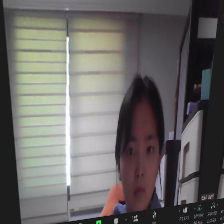

In [19]:
#예시하나의 바운딩 박스

label = data.train_ds[itemno][1]
bbox, clas = label.data
bbox = bbox.cuda()
clas = torch.tensor(clas).cuda()
bboxi = bbox
clasi = clas

# bboxi.shape, clasi.shape, bboxi, clasi
data.train_ds[itemno][0]

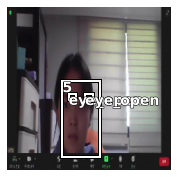

In [20]:
item.show(y=label)

In [21]:
ncells = 4
k = 1 # num boxes per cell
first_ctr = -1 + 2/(2*ncells)
last_ctr  =  1 - 2/(2*ncells)
a_x = np.repeat(np.linspace(first_ctr, last_ctr, ncells), ncells)
a_y = np.tile(np.linspace(first_ctr, last_ctr, ncells), ncells)
a_sz = np.array([2/ncells for _ in a_x])
anchors = torch.tensor(np.stack([a_x, a_y, a_sz, a_sz], axis=1)).type(torch.FloatTensor).cuda()
anchors

tensor([[-0.7500, -0.7500,  0.5000,  0.5000],
        [-0.7500, -0.2500,  0.5000,  0.5000],
        [-0.7500,  0.2500,  0.5000,  0.5000],
        [-0.7500,  0.7500,  0.5000,  0.5000],
        [-0.2500, -0.7500,  0.5000,  0.5000],
        [-0.2500, -0.2500,  0.5000,  0.5000],
        [-0.2500,  0.2500,  0.5000,  0.5000],
        [-0.2500,  0.7500,  0.5000,  0.5000],
        [ 0.2500, -0.7500,  0.5000,  0.5000],
        [ 0.2500, -0.2500,  0.5000,  0.5000],
        [ 0.2500,  0.2500,  0.5000,  0.5000],
        [ 0.2500,  0.7500,  0.5000,  0.5000],
        [ 0.7500, -0.7500,  0.5000,  0.5000],
        [ 0.7500, -0.2500,  0.5000,  0.5000],
        [ 0.7500,  0.2500,  0.5000,  0.5000],
        [ 0.7500,  0.7500,  0.5000,  0.5000]], device='cuda:0')

In [22]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

tensor([[-1.0000, -1.0000, -0.5000, -0.5000],
        [-1.0000, -0.5000, -0.5000,  0.0000],
        [-1.0000,  0.0000, -0.5000,  0.5000],
        [-1.0000,  0.5000, -0.5000,  1.0000],
        [-0.5000, -1.0000,  0.0000, -0.5000],
        [-0.5000, -0.5000,  0.0000,  0.0000],
        [-0.5000,  0.0000,  0.0000,  0.5000],
        [-0.5000,  0.5000,  0.0000,  1.0000],
        [ 0.0000, -1.0000,  0.5000, -0.5000],
        [ 0.0000, -0.5000,  0.5000,  0.0000],
        [ 0.0000,  0.0000,  0.5000,  0.5000],
        [ 0.0000,  0.5000,  0.5000,  1.0000],
        [ 0.5000, -1.0000,  1.0000, -0.5000],
        [ 0.5000, -0.5000,  1.0000,  0.0000],
        [ 0.5000,  0.0000,  1.0000,  0.5000],
        [ 0.5000,  0.5000,  1.0000,  1.0000]], device='cuda:0')

In [23]:
grid_sizes = torch.tensor(np.array([2/ncells]), requires_grad=False).type(torch.FloatTensor).unsqueeze(1).cuda()
grid_sizes

tensor([[0.5000]], device='cuda:0')

In [24]:
#함수는 이것만 돌리기 this is 찐

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
#         t = t[:,:-1].contiguous().cuda()
#         x = pred[:,:-1]
        # in fastai v1, the background is encoded as the first class, rather than the last one
        t = t[:,1:].contiguous().cuda()
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(ncat)

# remove padding - images in a minibatch will have a different number of objects
# those with fewer objects will have their bbox groundtruth tensor padded with 0s
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def ssd_1_loss(pred_bbox,pred_clas,bbox,clas):
    bbox,clas = get_y(bbox,clas)
    if len(bbox) == 0 and len(clas) == 0:
        return 0.0, 0.0
    a_ic = actn_to_bb(pred_bbox, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data).cuda()
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,False)
    gt_clas = clas[gt_idx].type(torch.LongTensor).cuda()
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[~pos] = 0 # background coded as 0
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(pred_clas, gt_clas)
    #print(f"loc_loss: {loc_loss}, clas_loss: {clas_loss}")
    return loc_loss, clas_loss

def ssd_loss(pred,targ_bb,targ_c):
    lcs,lls = 0.,0.
#    i = 1
#    for b_c,b_bb,bbox,clas in zip(*pred,targ_bb,targ_c):
    for pr_bb, pr_c, ta_bb, ta_c in zip(*pred, targ_bb, targ_c):
#         print(f"item {i}")
#         if i == 5:
#             pdb.set_trace()
#         i = i+1
#        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas)
        loc_loss, clas_loss = ssd_1_loss(pr_bb, pr_c, ta_bb, ta_c)
        lls += loc_loss
        lcs += clas_loss
#    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return 20*lls+lcs

# centre+height/width -> corners
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn.type(torch.FloatTensor)).cuda()
#     print(actn_bbs[:,:2]/2, grid_sizes, anchors[:,:2].shape)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes).cuda() + anchors[:,:2].cuda()
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

In [25]:
overlaps = jaccard(bbox.data.cuda(), anchor_cnr).cuda()
overlaps

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0474, 0.0181, 0.0000, 0.0000,
         0.3199, 0.1054, 0.0000, 0.0000, 0.1959, 0.0689, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0263, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0167, 0.0161, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [26]:
#제일 가능성있는 박스 2개
overlaps.max(0)
overlaps.max(1)

gt_overlap, gt_idx = map_to_ground_truth(overlaps)
gt_overlap, gt_idx

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0474, 0.0181, 0.0000, 0.0000,
         1.9900, 0.1054, 0.0000, 0.0000, 0.1959, 0.0689, 0.0000],
        device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [27]:
gt_clas = clas[gt_idx].type(torch.LongTensor).cuda(); gt_clas

tensor([ 4,  4,  4,  4,  4,  4,  4,  4,  4, 11,  4,  4,  4,  4,  4,  4],
       device='cuda:0')

In [28]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(~pos)[:,0]
pos_idx

tensor([9], device='cuda:0')

In [29]:
a_ic = actn_to_bb(b_bboxi, anchors)
gt_bbox = bbox.cuda()[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss  = F.cross_entropy(b_clasi, gt_clas)
loc_loss,clas_loss

(tensor(0.4189, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(3.4273, device='cuda:0', grad_fn=<NllLossBackward>))

In [30]:
a_ic[pos_idx] - gt_bbox[pos_idx]

tensor([[ 0.2693, -0.6452,  0.5083, -0.2528]], device='cuda:0',
       grad_fn=<SubBackward0>)

In [31]:
head_reg4 = SSD_Head(k=1, bias=-3.)
learn = cnn_learner(data, models.resnet34, loss_func=ssd_loss, custom_head=head_reg4)

epoch,train_loss,valid_loss,time
0,96.213966,#na#,00:40


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


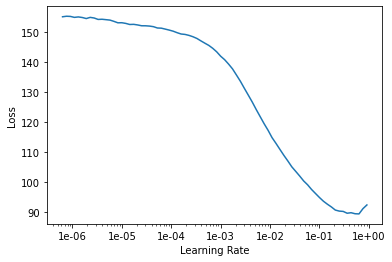

In [32]:
lr_find(learn)
learn.recorder.plot()

In [33]:
lr=0.5
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,time
0,53.238930,89.335518,00:37
1,353.015411,11611785.000000,00:34
2,1100.423950,2276100.000000,00:34
3,826.421753,1050.566650,00:34
4,395.569580,395.047363,00:35
5,245.239075,264.982758,00:34
6,129.144669,104.828362,00:34
7,76.540024,98.600388,00:36
8,71.637627,80.465431,00:41
9,61.754543,73.301483,00:43


C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\selmo\.conda\envs\fastai-v\lib\site-packages\fastai

In [205]:
learn.save('stage1-focal-loss')

In [48]:
def corners2hw(corners): return torch.cat([corners[:,:2], corners[:,2:] - corners[:,:2]], dim=1)

def show_results(max_show=0, printit=False):
    if max_show == 0:
        max_show = len(data.valid_ds)
    else:
        max_show = min(max_show, len(data.valid_ds))
    figsize = (10, max_show*5)
    fig,axs = plt.subplots(max_show, 2, figsize=figsize)
    i = 0
    while i < max_show:
        img, label = data.valid_ds[i]
        img.show(ax=axs[i,0], y=label, figsize=(5,5))        
        x, y = data.one_item(img)
#         print(x)
        pred_bb, pred_cc = learn.model(x)
        
        pred_cc = pred_cc.squeeze() # remove the singleton batch dimension
        pred_bb = pred_bb.squeeze()
#         print(pred_cc)
#         print(">>>>",pred_cc)
#         print('\n')
        pred_clas = pred_cc.max(1)[1].type(torch.IntTensor).cuda() # get the index of the max as the predicted clas
        pred_clas_prob = pred_cc.max(1)[0].sigmoid() # get the sigmoid of the max as the class probability
        print(pred_clas,pred_clas_prob)
        
        pos_idx = pred_clas > 0
#         if i == 1:
#             pdb.set_trace()
        a_ic = actn_to_bb(pred_bb, anchors)
        anc_cnr = anchor_cnr.clone()
        if printit:
            print(f"i={i}, a_ic orig")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor orig")
            print(anc_cnr[pos_idx])
        h = 224
        w = 224
        # convert to image coordinates (add 1 and scale by img size)
        a_ic.add_(1)
        anc_cnr.add_(1)
        if printit:
            print(f"i={i}, a_ic moved")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor moved")
            print(anc_cnr[pos_idx])        
        a_ic.mul_(torch.tensor([h/2, w/2, h/2, w/2]).cuda()).long()
        anc_cnr.mul_(torch.tensor([h/2, w/2, h/2, w/2]).cuda()).long()
        if printit:
            print(f"i={i}, a_ic rescaled")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor rescaled")
            print(anc_cnr[pos_idx])
        # select only bboxes that detect something else than background (0)
        pos_pred_clas = pred_clas[pos_idx]
        pos_a_ic = a_ic[pos_idx]
        if len(pos_pred_clas) > 0:
#             if i == 1:
#                 pdb.set_trace()
            pred_label = ImageBBox.create(224, 224, pos_a_ic.cpu(), pos_pred_clas.cpu(), data.train_ds.y.classes)
            img.show(ax=axs[i,1], y=pred_label, figsize=(5,5))
        else:
            img.show(ax=axs[i,1], figsize= (5,5))
        i = i+1

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       device='cuda:0', dtype=torch.int32) tensor([0.5028, 0.5006, 0.5041, 0.5014, 0.5101, 0.5093, 0.5060, 0.5126, 0.5108,
        0.7294, 0.5021, 0.5031, 0.5149, 0.5223, 0.5188, 0.5142],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       device='cuda:0', dtype=torch.int32) tensor([0.5028, 0.5007, 0.5041, 0.5013, 0.5101, 0.5093, 0.5060, 0.5126, 0.5109,
        0.7283, 0.5021, 0.5031, 0.5149, 0.5224, 0.5188, 0.5141],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0',
       dtype=torch.int32) tensor([0.5027, 0.5009, 0.5066, 0.5041, 0.5077, 0.5065, 0.5059, 0.5077, 0.5090,
        0.5066, 0.5039, 0.5030, 0.5169, 0.5237, 0.5178, 0.5133],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0',
      

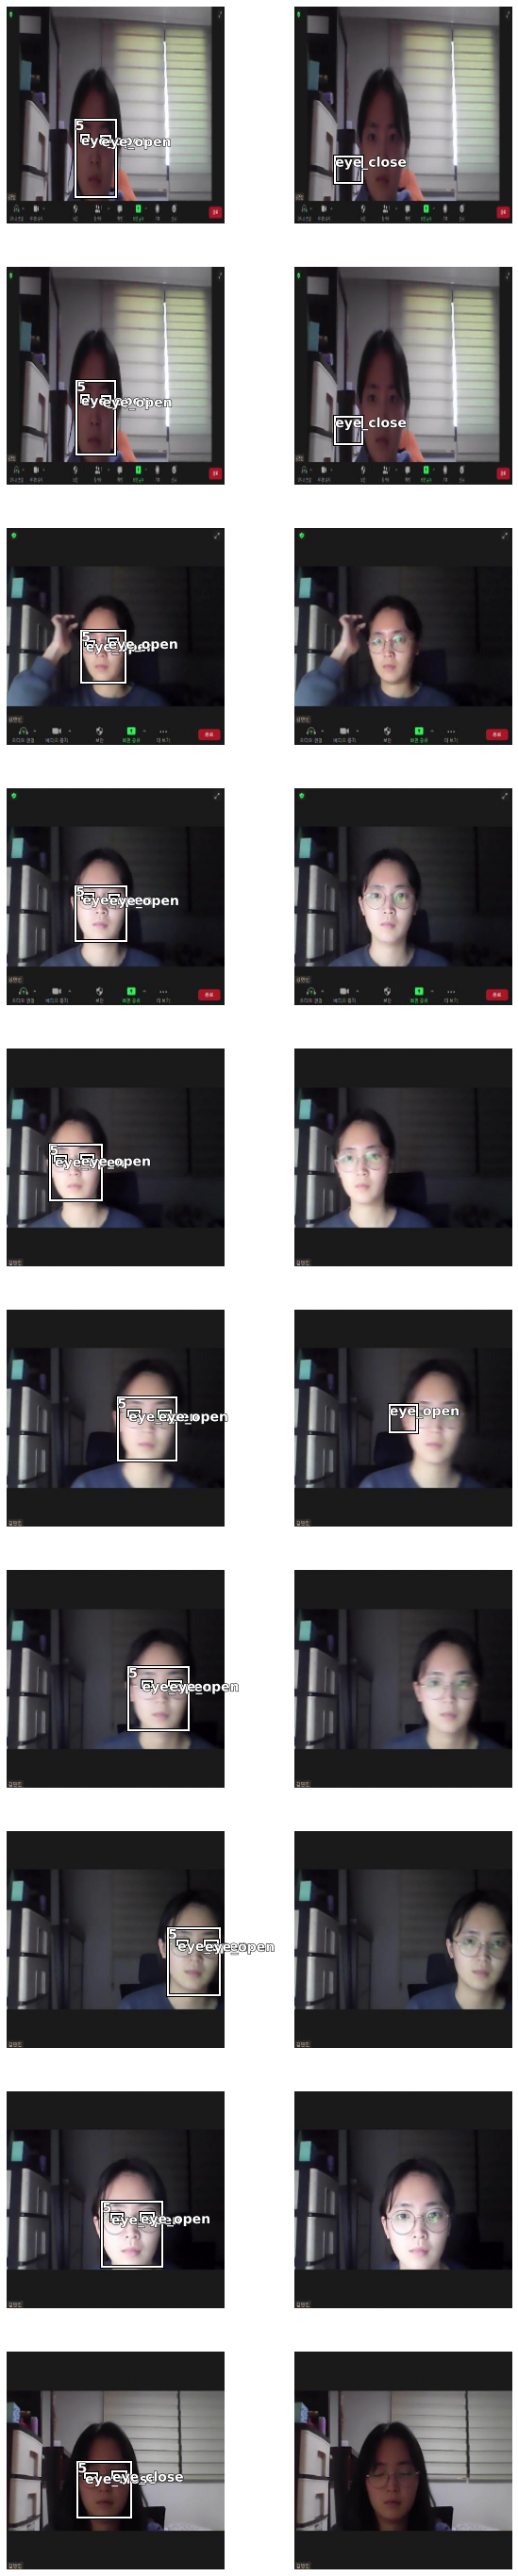

In [49]:
show_results(max_show=10, printit=False)

In [85]:
learn.export('model')

# import tensorflow as tf
# from tensorflow import reshape
from PIL import Image


In [38]:
img = open_image('WIN_20210131_03_09_21_Pro-058_jpg.rf.3551bfdc120ed519174f5d1e44b2fe05.jpg')

# image = Image.open('WIN_20210131_03_09_21_Pro-058_jpg.rf.3551bfdc120ed519174f5d1e44b2fe05.jpg')
# img = pil2tensor(image, dtype=np.int64)

# print(img.type(torch.IntTensor))

# # image_shape = tf.stack([3, 416, 416])
# # image = tf.reshape(img, img.shape)
# img.shape

# # data.Test = (ObjectItemList.from_folder(coco/'test').split_none())
# # data.Test
# open_image(img)

In [39]:
# path = Path('model/')
# learn = load_learner(path)

# data.labels

In [40]:
# learner = create_cnn(data=data, arch=arch, 
#                      metrics=[metrics.accuracy_thresh, partial(metrics.fbeta, beta=1)], 
#                      pretrained=False, 
#                      callback_fns=[
#                          ShowGraph, 
#                          partial(callbacks.tracker.EarlyStoppingCallback, monitor='fbeta', mode='max', min_delta=1e-4, patience=3),
#                          partial(callbacks.tracker.SaveModelCallback, monitor='fbeta', mode='max', name='resnet50_1118'),
# #                          partial(callbacks.tracker.ReduceLROnPlateauCallback, patience=1)
#                      ],
#                      path='./',
#                      model_dir='models'
#                     )

In [215]:
from fastai.basic_train import * 
from fastai.vision.data import ObjectCategoryList,ObjectCategoryProcessor,MultiCategoryList
from fastai.core import *
from fastai.vision.image import ImageBBox

from functools import partial

# overwrite...

def newcreate(h, w, bboxes, labels=None, classes=None, scale=True):
    "Create an ImageBBox object from `bboxes`."
    if isinstance(bboxes, np.ndarray) and bboxes.dtype == np.object: bboxes = np.array([bb for bb in bboxes])
    bboxes = tensor(bboxes).float()
    tr_corners = torch.cat([bboxes[:,0][:,None], bboxes[:,3][:,None]], 1)
    bl_corners = bboxes[:,1:3].flip(1)
    bboxes = torch.cat([bboxes[:,:2], tr_corners, bl_corners, bboxes[:,2:]], 1)
    flow = FlowField((h,w), bboxes.view(-1,2))
    ############################################################################################
    if labels is not None and len(labels)>0 and not isinstance(labels[0],Category):
#         print([torch.IntTensor(l.type(torch.IntTensor)) for l in labels])
#         new_labels = []
#         for l in labels:
#             temp = torch.IntTensor(l.type(torch.IntTensor))
#             new_labels.append(temp)
#         nnew_labels = (torch.stack(new_labels,dim=1)).squeeze(0)
#         print(len(nnew_labels))
#         print([l.sum() for l in nnew_labels])
        print([Category(l,classes[l]) for l in labels])
    return ImageBBox(flow, labels=nnew_labels, classes=classes, y_first=True, scale=scale)

def newreconstruct(classes,t, x):
    (bboxes, labels) = t
    if len((labels).nonzero()) == 0: return
    i = (labels).nonzero().min()
    bboxes,labels = bboxes[i:],labels[i:]
    print("x size",*x.size)
    return newcreate(*x.size, bboxes, labels=labels, classes=classes, scale=False)


# ocl = ObjectCategoryList(MultiCategoryList)
# # ocl.c_get = partial(class_method, ocl)
# ocl.i_get = partial(newreconstruct, ocl)

def newpredict(self, item:ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs):
        print("Return predicted class, label and probabilities for `item`.")
        batch = self.data.one_item(item)
        res = self.pred_batch(batch=batch, with_dropout=with_dropout)
        raw_pred,x = grab_idx(res,0,batch_first=batch_first),batch[0]
        norm = getattr(self.data,'norm',False)
        if norm:
            x = self.data.denorm(x)
            if norm.keywords.get('do_y',False): raw_pred = self.data.denorm(raw_pred)
        ds = self.data.single_ds
#         print(ds)
        pred = ds.y.analyze_pred(raw_pred, **kwargs)
        (bboxes, labels) = pred
#         print(labels[1])
#         print(">>>>>>>>" ,labels.argmax(1))
        pred = (bboxes,labels.argmax(1))
#         new_labels = []
#         for i in range(len(labels)):
#             temp = labels[i].type(torch.IntTensor).cuda()
#             new_labels.append(temp)
#         nnew_labels = (torch.stack(new_labels,dim=1)).squeeze(0)
#         print("this is labels:\n",nnew_labels)
#         pred = (bboxes, nnew_labels)
#         print("this is grab_idx:\n",grab_idx(x,0))
        x = ds.x.reconstruct(grab_idx(x, 0))
#         print(ds.y.pad_idx)
        y = ds.y.reconstruct(pred, x) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
        return (x, y, pred,raw_pred) if return_x else (y, pred,raw_pred)

result = newpredict(self=learn,item= img, return_x=False, batch_first=True, with_dropout=False)
# print(x)
# print(result)
# log_preds = learn.predict_dl(dl)
preds = np.argmax(pred, axis=1)  # from log probabilities to 0 or 1 - get the max on either side
probs = np.exp(pred[:,1]) 


# log_preds_test= learn.get_preds()


Return predicted class, label and probabilities for `item`.
Return predicted class, label and probabilities for `item`.


ValueError: only one element tensors can be converted to Python scalars

In [210]:
learn.load('stage1-focal-loss')

Learner(data=ImageDataBunch;

Train: LabelList (605 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: dataset1.v1.coco\images;

Valid: LabelList (173 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: dataset1.v1.coco\images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
 

In [208]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

TypeError: only integer tensors of a single element can be converted to an index